<a href="https://colab.research.google.com/github/mynteshav/CodeClause_Gender_and_age_detection_system1/blob/main/CodeClause_Gender_and_age_detection_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import random
from PIL import Image
import tensorflow as tf
from google.colab import drive
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.utils import plot_model

In [154]:
#path = Path("../input/utkface-new/UTKFace")
drive.mount('/content/drive')
path = Path("/content/drive/MyDrive/UTKFace/7")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))
print(filenames)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['10_0_0_20170120220628194.jpg.chip.jpg', '10_1_1_20170109203522559.jpg.chip.jpg', '10_1_0_20170110220649364.jpg.chip.jpg', '10_0_0_20170110224238891.jpg.chip.jpg', '10_1_0_20170109203759972.jpg.chip.jpg', '10_0_0_20170110225421531.jpg.chip.jpg', '10_1_0_20170109203917216.jpg.chip.jpg', '10_0_0_20170110221714752.jpg.chip.jpg', '10_0_0_20170103233459275.jpg.chip.jpg', '10_0_4_20170103200443015.jpg.chip.jpg', '10_1_0_20170103200654246.jpg.chip.jpg', '10_1_0_20170109202346880.jpg.chip.jpg', '10_0_0_20170110224725285.jpg.chip.jpg', '10_0_4_20170103200335831.jpg.chip.jpg', '10_0_0_20170117143048181.jpg.chip.jpg', '10_0_0_20170110224500062.jpg.chip.jpg', '10_1_0_20170109203608654.jpg.chip.jpg', '10_0_0_20170110220514186.jpg.chip.jpg', '10_0_0_20170110225402690.jpg.chip.jpg', '10_0_0_20170110220251986.jpg.chip.jpg', '10_0_0_20170110224253445.jpg.chip.jpg', '10_0_0_2

In [155]:
print(len(filenames))

2923


In [156]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(path)):
    image_path = os.path.join(path, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/2924 [00:00<?, ?it/s]

In [157]:
df = pd.DataFrame()
df['Image'], df['Age'], df['Gender'] = image_paths, age_labels, gender_labels
df.head()

,Image,Age,Gender
0,/content/drive/MyDrive/UTKFace/7/10_0_0_201701...,10,0
1,/content/drive/MyDrive/UTKFace/7/10_1_1_201701...,10,1
2,/content/drive/MyDrive/UTKFace/7/10_1_0_201701...,10,1
3,/content/drive/MyDrive/UTKFace/7/10_0_0_201701...,10,0
4,/content/drive/MyDrive/UTKFace/7/10_1_0_201701...,10,1


In [158]:
print(f'Number of image_paths:{len(image_paths)} Number of age_labels:{len(age_labels)} Number of gender_labels:{len(gender_labels)}')

Number of image_paths:2924 Number of age_labels:2924 Number of gender_labels:2924


In [159]:
gender_dict = {0:'Male', 1: 'Female'}

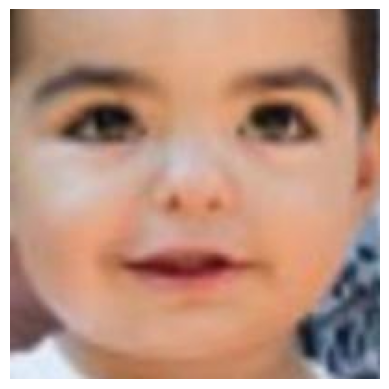

In [160]:
from PIL import Image
img = Image.open(df['Image'][200])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='Age', ylabel='Density'>

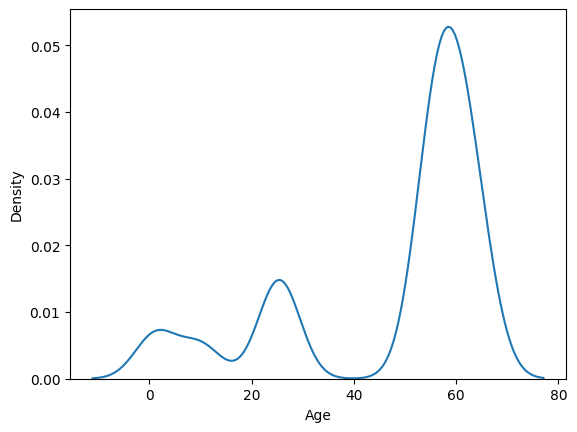

In [161]:
sns.distplot(df['Age'],hist=False)

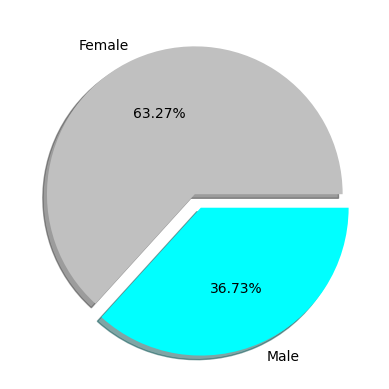

In [162]:

s=pd.Series(df['Gender']).value_counts()
colors=['silver','cyan']
plt.pie(s,labels=['Female','Male'],colors = colors, explode = [0, 0.1], shadow = True, autopct = '%.2f%%')
plt.show()
#sns.countplot(df['Gender'])

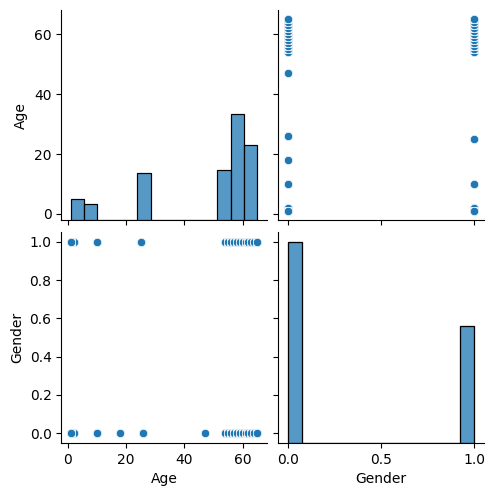

In [163]:
sns.pairplot(df)

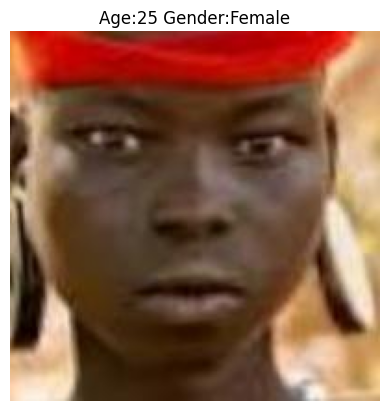

In [164]:
rand_index=random.randint(0,len(image_paths))
age=df['Age'][rand_index]
gender=df['Gender'][rand_index]
IMG= Image.open(df['Image'][rand_index])
plt.title(f'Age:{age} Gender:{gender_dict[gender]}')
plt.axis('off')
plt.imshow(IMG)

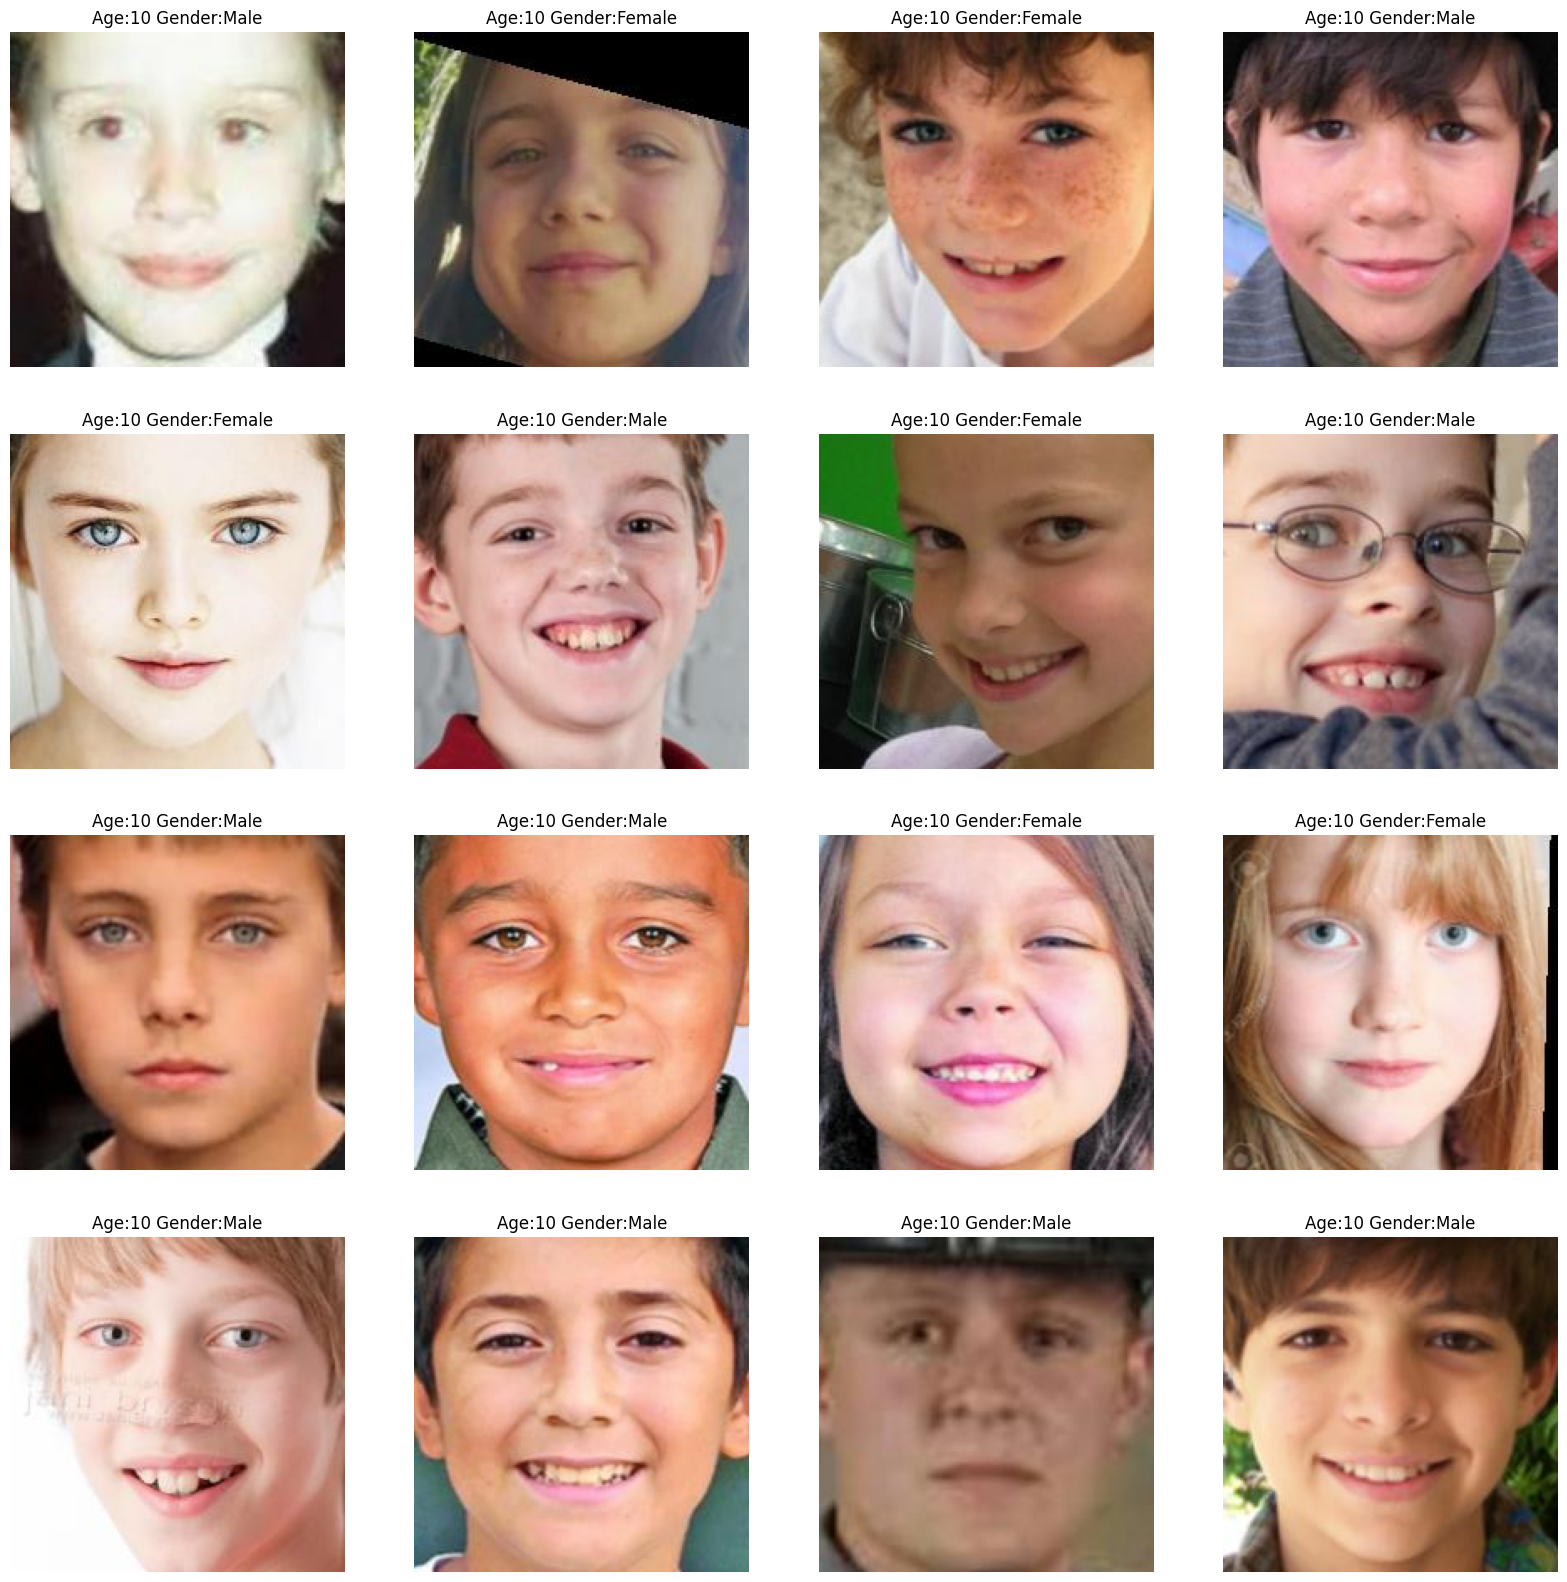

In [165]:
plt.figure(figsize=(20,20))
sam=df.iloc[0:16]
for index,sam,age,gender in sam.itertuples():
  plt.subplot(4,4,index+1)
  img=load_img(sam)
  img=np.array(img)
  plt.axis('off')
  plt.title(f'Age:{age} Gender:{gender_dict[gender]}')
  plt.imshow(img)

In [166]:
def extract_image(images):
  features=list()
  for image in tqdm(images):
    img=load_img(image,grayscale=True)
    img=img.resize((128,128),Image.ANTIALIAS)
    img=np.array(img)
    features.append(img)
  features=np.array(features)
  features=features.reshape(len(features),128,128,1)
  return features



In [167]:
X=extract_image(df['Image'])

  0%|          | 0/2924 [00:00<?, ?it/s]

In [168]:
X.shape

(2924, 128, 128, 1)

In [169]:
X=X / 255.0

In [170]:
y_gender=np.array(df['Gender'])
y_age=np.array(df['Age'])

In [171]:
input_shape=(128,128,1)

In [172]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(32, kernel_size=(3,3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(32, kernel_size=(3,3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(32, kernel_size=(3,3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2))(conv_4)
flatten = Flatten()(maxp_4)
dense_1 = Dense(256,  activation = 'relu')(flatten)
dense_2 = Dense(256,  activation = 'relu')(flatten)
dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)
output_1 = Dense (1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense (1, activation='relu', name='age_out')(dropout_2)
model = Model(inputs=[inputs], outputs=[output_1, output_2])
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])



In [173]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 126, 126, 32  320         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 63, 63, 32)  0           ['conv2d_8[0][0]']               
                                                                                            

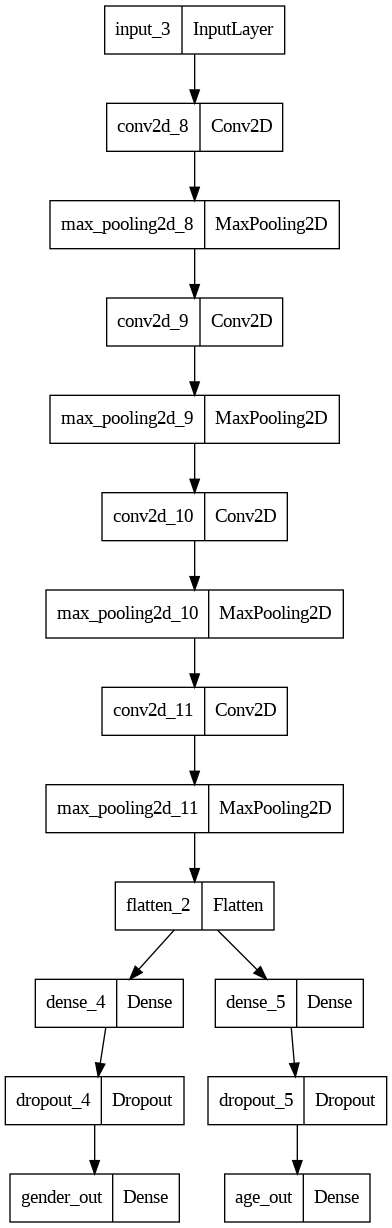

In [174]:
plot_model(model)

In [175]:
result = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
74/74 [==============================] - 55s 723ms/step - loss: 22.7172 - gender_out_loss: 0.6892 - age_out_loss: 22.0280 - gender_out_accuracy: 0.5964 - age_out_accuracy: 0.0577 - val_loss: 20.8151 - val_gender_out_loss: 0.6259 - val_age_out_loss: 20.1893 - val_gender_out_accuracy: 0.6701 - val_age_out_accuracy: 0.0000e+00
Epoch 2/30
74/74 [==============================] - 51s 685ms/step - loss: 18.3883 - gender_out_loss: 0.6696 - age_out_loss: 17.7187 - gender_out_accuracy: 0.6092 - age_out_accuracy: 0.0603 - val_loss: 6.5553 - val_gender_out_loss: 0.6315 - val_age_out_loss: 5.9238 - val_gender_out_accuracy: 0.6701 - val_age_out_accuracy: 0.0000e+00
Epoch 3/30
74/74 [==============================] - 54s 731ms/step - loss: 17.5926 - gender_out_loss: 0.6718 - age_out_loss: 16.9208 - gender_out_accuracy: 0.6075 - age_out_accuracy: 0.0603 - val_loss: 7.5788 - val_gender_out_loss: 0.6427 - val_age_out_loss: 6.9361 - val_gender_out_accuracy: 0.6701 - val_age_out_accuracy: 0.00

<Figure size 640x480 with 0 Axes>

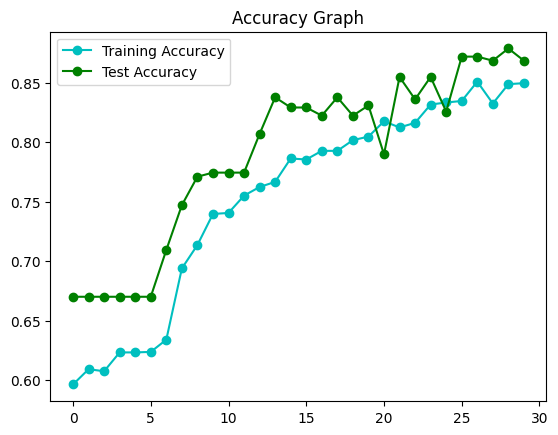

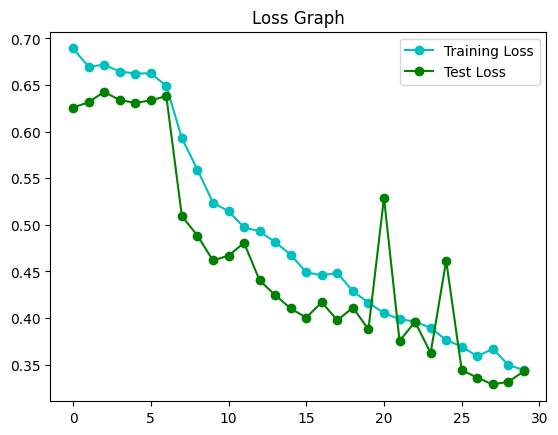

<Figure size 640x480 with 0 Axes>

In [176]:
acc = result.history['gender_out_accuracy']
val_acc = result.history['val_gender_out_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'c', label='Training Accuracy',marker='o')
plt.plot(epochs, val_acc, 'g', label='Test Accuracy',marker='o')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()
loss = result.history['gender_out_loss']
val_loss = result.history['val_gender_out_loss']
plt.plot(epochs, loss, 'c', label='Training Loss',marker='o')
plt.plot(epochs, val_loss, 'g', label='Test Loss',marker='o')
plt.title('Loss Graph')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

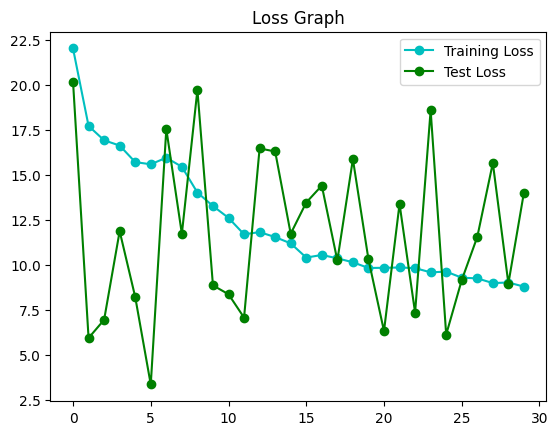

<Figure size 640x480 with 0 Axes>

In [177]:
loss = result.history['age_out_loss']
val_loss = result.history['val_age_out_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'c', label='Training Loss',marker='o')
plt.plot(epochs, val_loss, 'g', label='Test Loss',marker='o')
plt.title('Loss Graph')
plt.legend()
plt.figure()

Original Gender:  Male Original Age:  55
1/1 [==============================] - 0s 115ms/step
Predicted Gender:  Male Predicted Age:  46


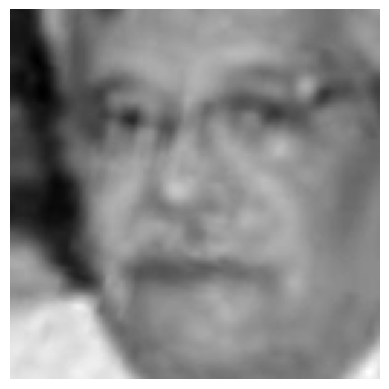

In [178]:
image_index = 1100
print("Original Gender: ", gender_dict[y_gender[image_index]], 'Original Age: ', y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender: ", pred_gender, "Predicted Age: ", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap='gray')


Original Gender:  Female Original Age:  62
1/1 [==============================] - 0s 28ms/step
Predicted Gender:  Female Predicted Age:  52


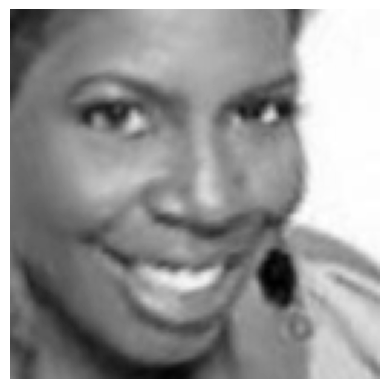

In [179]:
image_index = 2500
print("Original Gender: ", gender_dict[y_gender[image_index]], 'Original Age: ', y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender: ", pred_gender, "Predicted Age: ", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap='gray')

Original Gender:  Male Original Age:  59
1/1 [==============================] - 0s 26ms/step
Predicted Gender:  Male Predicted Age:  59


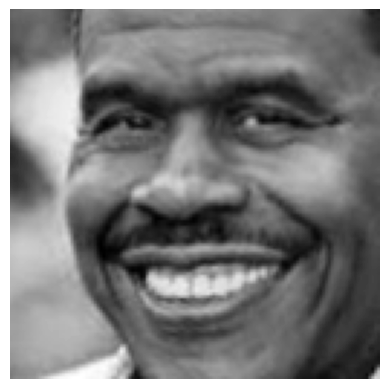

In [180]:
image_index = 1900
print("Original Gender: ", gender_dict[y_gender[image_index]], 'Original Age: ', y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender: ", pred_gender, "Predicted Age: ", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap='gray')